

```
# Dit is opgemaakt als code
```

# DCGAN to generate grayscale images


**OVERVIEW**

This model uses the parameters as in the 'CHANGE' box + *LeakyReLU* as activation layer in both the gen. and disc. 

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import cv2
import random as rd
import PIL

# CHANGE

_____________________________________________________________________

In [2]:
# Image size (height x width)
ih = 64
iw = 64

# Grayscale or RGB
ch = 'grayscale'

# Layer adapt
ksize = 4 # Kernel size : was '4' for 64x64 image
ssize = 2 # Stride size : was '2' for 64x64 image

# Batch size
batch_size = 32

# TPU
print('Are you going to use TPU?')
use_tpu = 'n'

Are you going to use TPU?


_____________________________________________________________________

**TPU Setup (Optional & Automatic)**

In [3]:
if(use_tpu == 'y' or use_tpu == 'Y'):
    # Detect and init. TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

    # Initialize distributed TPU strategy
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [4]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.2


In [5]:
try: 
    os.mkdir("/kaggle/working/checkpoints")
    print("Path for checkpoints has been created!")
except:
    print("Path already exists")

Path for checkpoints has been created!


In [6]:
try:
    os.mkdir("/kaggle/working/generated_images")
    print("Path for generated images has been created!")
except:
    print("Path already exists")

Path for generated images has been created!


## Prepare CelebA data

We'll use face images from the CelebA dataset, resized to 64x64.

In [7]:
# Overwrite if TPU is used
if use_tpu == 'y' or use_tpu == 'Y':
    batch_size = 16 * tpu_strategy.num_replicas_in_sync

In [8]:
if use_tpu == 'y' or use_tpu == 'Y': 
    # Step 1: Get the credentail from the Cloud SDK
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    user_credential = user_secrets.get_gcloud_credential()
    user_secrets.set_tensorflow_credential(user_credential)

    # Step 3: Use a familiar call to get the GCS path of the dataset
    !gcloud config set project 'solid-topic-344315'
    
    GCS_DS_PATH = 'gs://thesis_data_max/classified_data'
    

    
else: path_root = '/kaggle/input/thesis-data'

In [9]:
!gsutil ls gs://thesis_data_max/classified_data

ServiceException: 401 Anonymous caller does not have storage.objects.get access to the Google Cloud Storage object.


Create a dataset from our folder, and rescale the images to the [0-1] range:

In [10]:
im_si = (ih, iw)

if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1


In [11]:
if (use_tpu == 'y' or use_tpu == 'Y'):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        GCS_DS_PATH, 
        label_mode = None,
        color_mode = ch,
        image_size = im_si,
        interpolation='bicubic',
        batch_size = batch_size
)
    
if (use_tpu == 'n' or use_tpu == 'N'):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        path_root, 
        label_mode = None,
        color_mode = ch,
        image_size = im_si,
        interpolation='bicubic',
        batch_size = batch_size
    )

dataset = dataset.map(lambda x : x / 255.0)

Found 26548 files belonging to 1 classes.


2022-03-21 14:01:06.424559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 14:01:06.519911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 14:01:06.520676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-21 14:01:06.525073: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Let's display a sample image:

## Create the discriminator

It maps a 64x64 image to a binary classification score.

In [12]:
def create_discriminator():
  return keras.Sequential(
      [
        
          layers.Conv2D(ih, kernel_size=ksize, strides=ssize, padding="same",
                        input_shape=(ih, iw, chnum)),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2D(2*ih, kernel_size=ksize, strides=ssize, padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2D(2*ih, kernel_size=ksize, strides=ssize, padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Flatten(),
          layers.Dropout(0.2),
          layers.Dense(1, activation="sigmoid"),
      ],
      name="discriminator",
  )


## Create the generator

It mirrors the discriminator, replacing `Conv2D` layers with `Conv2DTranspose` layers.

In [13]:
latent_dim = ih
sih = ih//8
siw = iw//8

def create_generator():
  return keras.Sequential(
      [
          keras.layers.InputLayer(input_shape=(latent_dim)),
          
          layers.Dense(sih * siw * latent_dim),
          layers.Reshape((sih, siw, latent_dim)),
          layers.Conv2DTranspose(latent_dim, kernel_size=ksize, strides=ssize, padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2DTranspose(2*latent_dim, kernel_size=ksize, strides=ssize, padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2DTranspose(4*latent_dim, kernel_size=ksize, strides=ssize, padding="same"),
          layers.LeakyReLU(alpha=0.2),
          layers.Conv2D(chnum, kernel_size=ksize+1, padding="same", activation="sigmoid"),
      ],
      name="generator",
  )


In [14]:
if use_tpu == 'y' or use_tpu == 'Y':
    with tpu_strategy.scope():
        generator = create_generator()
        discriminator = create_discriminator()
else:  
    generator = create_generator()
    discriminator = create_discriminator()

In [15]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1088      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

In [16]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              266240    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 64)        65600     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 256)       52

## Override `train_step`

In [17]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
  


**Other GAN Script**

In [18]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [19]:
def discriminator_loss(real_output, fake_output, d_loss):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    d_loss.append(total_loss)
    return total_loss

In [20]:
def generator_loss(fake_output, g_loss):
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    g_loss.append(fake_loss)
    return fake_loss

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Create a callback that periodically saves generated images

In [22]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        start = time.time()
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("/kaggle/working/generated_images/generated_img_%03d_%d.png" % (epoch, i))
    
        # Save the model every 15 epochs (WAS 15)
        if (epoch + 1) % 15 == 0:
          checkpoint.save(file_prefix = checkpoint_prefix)



**Restore checkpoints if they exists**

In [23]:
checkpoint_dir = '/kaggle/working/checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=create_generator(),
                                 discriminator=create_discriminator())

In [24]:
checkpoint_directory = '/kaggle/input/dcgan-tweaking-kaggle/checkpoints'

In [25]:
if(os.path.exists(checkpoint_directory)):
    print("A checkpoint was found!")
    ckpt_exists = False
else: 
    print("Checkpoitn was not found!")
    ckpt_exists = False

Checkpoitn was not found!


In [26]:
if ckpt_exists == True:
    epochs = 16
    chkpt_restore_path = tf.train.latest_checkpoint(checkpoint_directory)
    print(chkpt_restore_path)
    num_ckpt = chkpt_restore_path[-1:]
    checkpoint.restore(chkpt_restore_path)

In [27]:
   if ckpt_exists == True:
    if use_tpu == 'y' or use_tpu == 'Y':
        with tpu_strategy.scope():
            gan = GAN(discriminator=checkpoint.discriminator, generator=checkpoint.generator, latent_dim=latent_dim)

            gan.compile(
            d_optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Was 0.0001
            g_optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Was 0.0001
            loss_fn=keras.losses.BinaryCrossentropy(),
            )

    else: 
        gan = GAN(discriminator=checkpoint.discriminator, generator=checkpoint.generator, latent_dim=latent_dim)

        gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Was 0.0001
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Was 0.0001
        loss_fn=keras.losses.BinaryCrossentropy(),
        )

    #steps_per_epoch = 2500 // batch_size
    gan.fit(
      dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
    )

## Train the end-to-end model

In [28]:
if ckpt_exists == False:
    epochs = 91  # In practice, use ~100 epochs

    if use_tpu == 'y' or use_tpu == 'Y':
        with tpu_strategy.scope():
            gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

            gan.compile(
            d_optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Was 0.0001
            g_optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Was 0.0001
            loss_fn=keras.losses.BinaryCrossentropy(reduction = tf.keras.losses.Reduction.NONE),
            )

    else: 
        gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

        gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Was 0.0001
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0001), # Was 0.0001
        loss_fn=keras.losses.BinaryCrossentropy(),
        )

    #steps_per_epoch = 2500 // batch_size
    gan.fit(
      dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
    )

2022-03-21 14:01:11.427549: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/91


2022-03-21 14:01:15.211136: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


830/830 [==============================] - 115s 128ms/step - d_loss: 0.3169 - g_loss: 4.6338
Epoch 2/91
830/830 [==============================] - 42s 51ms/step - d_loss: 0.3658 - g_loss: 2.2689
Epoch 3/91
830/830 [==============================] - 42s 51ms/step - d_loss: 0.3822 - g_loss: 2.9527
Epoch 4/91
830/830 [==============================] - 42s 51ms/step - d_loss: 0.2908 - g_loss: 3.2724
Epoch 5/91
830/830 [==============================] - 42s 51ms/step - d_loss: 0.3376 - g_loss: 2.8422
Epoch 6/91
830/830 [==============================] - 42s 51ms/step - d_loss: 0.3178 - g_loss: 3.1141
Epoch 7/91
830/830 [==============================] - 42s 51ms/step - d_loss: 0.3743 - g_loss: 2.7880
Epoch 8/91
830/830 [==============================] - 42s 51ms/step - d_loss: 0.3640 - g_loss: 2.3899
Epoch 9/91
830/830 [==============================] - 42s 51ms/step - d_loss: 0.4327 - g_loss: 2.4876
Epoch 10/91
830/830 [==============================] - 42s 51ms/step - d_loss: 0.3816 - g_l

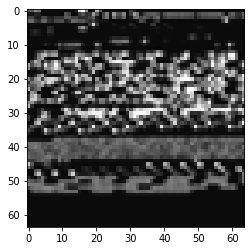

In [29]:
for x in dataset:
  i = rd.randint(0,26458)
  plt.imshow((x.numpy() * 255).astype("int32")[0], cmap='gray')
  break

Some of the last generated images around epoch 30
(results keep improving after that):


# Checkpoint Restore